In [1]:
# Dependencies
import pandas as pd
import numpy as np
import os
import datetime as dt

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
startDate='2017-08-19'
endDate='2017-08-23'

# Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# function definitions
def isDate(d, checker=False):
     if len(d.split('-')) == 3 and len(d.split('-')[0]) == 4 and len(d.split('-')[1]) == 2 and len(d.split('-')[2]) == 2:
         checker = True
     else:
         print(f'Please enter date correctly! YYYY-MM-DD')
     return checker
def yearAgoDate(d):
     if isDate(d):
         Year = int(d.split('-')[0])
         Month = int(d.split('-')[1])
         Day = int(d.split('-')[2])
     return dt.date(Year-1, Month, Day)

In [11]:
 # Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
 # function definition
 def setDate(dateType, isCorrect=False):
 #     print(isCorrect)
     while not isCorrect:
         if dateType == 'dept':
             startDate = input(f'Please enter your departure date YYYY-MM-DD: ')
             isCorrect = isDate(startDate)
             return startDate
         elif dateType == 'arr':
             endDate = input(f'Please enter your arriving date YYYY-MM-DD: ')
             isCorrect = isDate(endDate)
             return endDate
         else:
             print('wrong date type: use dept or arr')

In [12]:
 # set Dates
 print("Let's start trip planning!")
 startDate = setDate('dept')

Let's start trip planning!
Please enter your departure date YYYY-MM-DD: 2017-08-19


In [13]:
 endDate = setDate('arr')

Please enter your arriving date YYYY-MM-DD: 2017-08-23


In [14]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

In [15]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Get a list of column names and types
ms_columns = inspector.get_columns('measurements')
for c in ms_columns:
    print(c['name'], c['type'])

In [17]:
st_columns = inspector.get_columns('stations')
for c in st_columns:
    print(c['name'], c['type'])

In [18]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
Base = automap_base()
Base.prepare(engine, reflect=True)
Mea = Base.classes.measurement
Sta = Base.classes.station

In [19]:
session = Session(engine)
session.query(func.count(Mea.date)).all()

[(19550)]

In [20]:
session.query(func.count(Sta.name)).all()

[(9)]

# Exploratory Climate Analysis

In [21]:
# get the latest date in Measurement
# get a year ago data from latestDate
# Design a query to retrieve the last 12 months of precipitation data
# Select only the date and prcp values
# Load the query results into a Pandas DataFrame

latest = session.query(Mea.date).order_by(Mea.date.desc()).first()[0]
lYear = int(latest.split('-')[0])
lMonth = int(latest.split('-')[1])
lDay = int(latest.split('-')[2])

latestDate = dt.date(lYear, lMonth, lDay)

prevDate = yearAgoDate(latest)

prcp = pd.read_sql(session.query(Mea.date, Mea.prcp).filter(Mea.date > prevDate, Mea.date <= latestDate).order_by(Mea.date).statement, session.bind)

In [22]:
# set date as datetime
prcp['date']=pd.to_datetime(prcp['date'])
type(prcp.loc[0,'date'])

pandas._libs.tslibs.timestamps.Timestamp

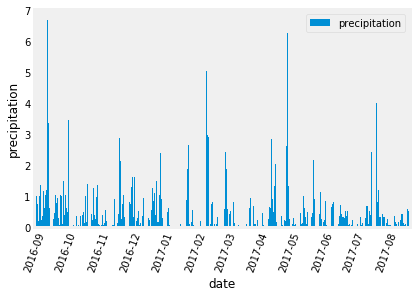

In [23]:
# set the index to the date column.
prcp_i = prcp.set_index('date')
%matplotlib inline
p1 = plt.bar(prcp_i.index, prcp_i['prcp'])
plt.xticks(rotation=70)
plt.legend([p1],['precipitation'])
ax=plt.gca()
ax.set_xlabel('date')
ax.set_ylabel('precipitation')
ax.grid()
ax.set_xlim(['2016-09-01','2017-08-23'])
plt.show()

In [24]:
# Use Pandas to print the summary statistics for the precipitation data.
prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to calculate the total number of stations.
session.query(func.count(Sta.name)).all()

[(9)]

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-09-01', '2017-08-23'))

[(58.0, 74.49424228466145, 87.0)]


In [27]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-08-19', '2017-08-23'))

[(71.0, 79.61111111111111, 85.0)]


In [28]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order
sel = [Sta.name, Mea.station, Mea.date, Mea.prcp, Mea.tobs]
st_DF=pd.read_sql(session.query(*sel).filter(Mea.station == Sta.station).order_by(Mea.date).statement, session.bind)
st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station']
# Which station has the highest number of observations?
highestSt = st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station'].index[0]
highestCnt = st_DF.groupby('name').count().sort_values(by='station', ascending=False)['station'][0]
# print results
print(f'{highestSt} has The highest number of observations, the observation count is {highestCnt}.')

WAIHEE 837.5, HI US has The highest number of observations, the observation count is 2772.


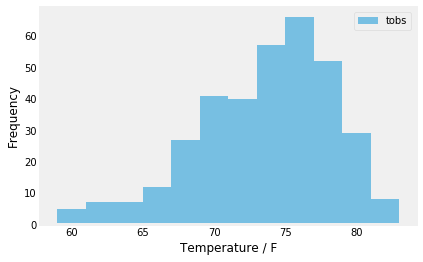

In [29]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
tobs_past12 = pd.read_sql(session.query(Mea.date, Sta.name, Mea.tobs).filter(Mea.station == Sta.station, Mea.date > prevDate, Mea.date < latestDate).order_by(Mea.date).statement, session.bind)
# tobs_past12

# Filter by the station with the highest number of observations.
tobs_past12.loc[tobs_past12['name']== highestSt]

# Plot the results as a histogram with bins=12.
tobs_past12.loc[tobs_past12['name']== highestSt].plot.hist(bins=12, alpha=0.5)
ax=plt.gca()
ax.set_xlabel('Temperature / F')
ax.grid()

plt.show()

In [30]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start, end):
    if start > end:
        start_ = end
        end_ = start
    else:
        start_ = start
        end_ = end
    
    start_prev = yearAgoDate(start_)
    end_prev = yearAgoDate(end_)

    tobs_DF = pd.read_sql(session.query(Mea.tobs).filter(Mea.date > start_prev, Mea.date < end_prev).statement, session.bind)
    return {
        'min': tobs_DF.describe().loc[tobs_DF.describe().index=='min']['tobs'][0],
        'avg': tobs_DF.describe().loc[tobs_DF.describe().index=='mean']['tobs'][0],
        'max': tobs_DF.describe().loc[tobs_DF.describe().index=='max']['tobs'][0],
        'start_date': start_prev,
        'end_date': end_prev
    }

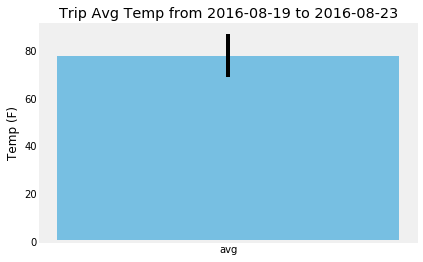

In [35]:

# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
tempData = calc_temps(startDate, endDate)

# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
plt.bar(1,tempData['avg'],yerr=tempData['max']-tempData['min'], alpha=0.5)
plt.xticks([1],['avg'])
ax=plt.gca()
ax.set_ylabel('Temp (F)')
sDate = tempData['start_date']
eDate = tempData['end_date']
plt.title(f'Trip Avg Temp from {sDate} to {eDate}')

ax.grid()
plt.show()

# Optional Recommended Analysis

In [32]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
# Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.
def collect_prcp(start, end):
    if start > end:
        start_ = end
        end_ = start
    else:
        start_ = start
        end_ = end
    
    start_prev = yearAgoDate(start_)
    end_prev = yearAgoDate(end_)

    return pd.read_sql(session.query(Mea.date, Mea.station, Mea.prcp).filter(Mea.date > start_prev, Mea.date < end_prev).statement, session.bind)

df = collect_prcp(startDate, endDate)
df.groupby('station').max()['prcp']

station
USC00513117    0.94
USC00514830    0.00
USC00516128    1.20
USC00517948     NaN
USC00519281    2.32
USC00519397    0.40
USC00519523    0.41
Name: prcp, dtype: float64

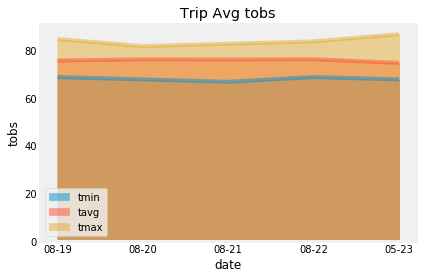

In [36]:
# Create a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
def daily_normals(day):
    df = pd.read_sql(session.query(Mea.date, Mea.tobs).filter(Mea.date.like("%" + day)).statement, session.bind)
    return {
        'min': df.describe().loc[df.describe().index=='min']['tobs'][0],
        'avg': df.describe().loc[df.describe().index=='mean']['tobs'][0],
        'max': df.describe().loc[df.describe().index=='max']['tobs'][0],
        'date': day,
    }
# Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
dates = ['08-19','08-20','08-21','08-22','05-23']
tmin = []
tmax = []
tavg = []
for day in dates:
    result = daily_normals(day)
    tmin.append(result['min'])
    tmax.append(result['max'])
    tavg.append(result['avg'])

# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
result_DF = pd.DataFrame({
    'date': dates,
    'tmin': tmin,
    'tavg': tavg,
    'tmax': tmax
})
# result_DF

# Use Pandas to plot an area plot (stacked=False) for the daily normals.
plt1 = result_DF.plot.area(stacked=False)
plt.xticks([0,1,2,3,4],dates)
plt1.set_xlabel('date')
plt1.set_ylabel('tobs')
plt.grid()
plt.title(f'Trip Avg tobs')

plt.show()